In [3]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

# feature selection
from sklearn.feature_selection import f_classif # chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV
# from sklearn.decomposition import PCA

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb

# model selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline #make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# Técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [4]:
# semilla de aleatorización

seed = 99

In [5]:
# Cargar los datos
data = pd.read_csv('Datasets/datos_procesados.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')

Número de filas: 4687, Númerode columnas:24


In [6]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

# variable objetivo (.pop elimina la col de X, que también es un paso necesario)
y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

In [7]:
# SMOTE

# Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')

smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

In [8]:
# 1ª etapa (with all features)

import time
start_time = time.time()

# Elegir el algoritmo
model = DecisionTreeClassifier(class_weight='balanced',
                               random_state=seed)

# Definir variabs numéricas y categóricas
scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categ_features = [feature for feature in X_train.columns if feature not in scaler_features]

# Column transformer (transformaciones previas de la variabs)
col_transformer = ColumnTransformer(
    [
    ('encoder', OneHotEncoder(drop=["3-9"]), categ_features),
    ('scaler', RobustScaler(), scaler_features)
    ], remainder='passthrough')
# (nota: para árboles, en lugar de dummies, también podríamos usar OrdinalEncoder, que codifica a 0,1,2,3...)

# Pipeline
pipe = Pipeline([
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('algorithm', model)        
])

# Tuneado del modelo (malla de paráms)
parametros = {
    "algorithm__criterion": ['gini','entropy','log_loss'],
    "algorithm__splitter": ['best','random'],
    "algorithm__max_features": ['sqrt','log2', None],
    # None es para max_features=n_features
}
# Nota: n_features < max_features leads to a reduction of variance and an increase in bias

# Repeated cross_val (stratified)
# cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# combinamos todo
gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros, scoring='f1') # (*)

# buscamos el mejor modelo (OJO, con smote --> X_resampled, y_resampled; sin smote --> X_train, y_train)

# opción a) sin resample y con class_weight='balanced':
grid_model = gsearch.fit(X_train, y_train)

# opción b) con resample (SMOTE)
# grid_model = gsearch.fit(X_train_resampled, y_train_resampled)

    # A diff de otros clasificadores como regr log, el árbol no se ve tan afectado por el desbalanceo de los datos
    # De hecho, se consiguen buenos bueno resultados sin hacer remuestreo (smote).
    # De todas formas, podemos mejorar el resultado porque aquí también está el parám 'class_weigth'
    # para precisamente lidiar con el desbalanceo

# resultados
print("Best CV score:", grid_model.best_score_)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

Best CV score: 0.9854340811598999

Tiempo de ejecución: 98.32262563705444 segundos


In [9]:
# Mejor estimador
grid_model.best_estimator_.named_steps['algorithm']

DecisionTreeClassifier(class_weight='balanced', random_state=99)

In [10]:
# Importancias de todas las variables en el mejor estimador (para luego)
importances_all = gsearch.best_estimator_.named_steps['algorithm'].feature_importances_

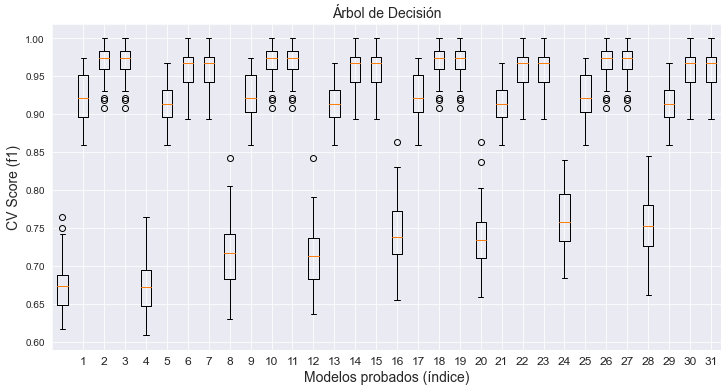


Tiempo de ejecución: 63.33578658103943 segundos


In [11]:
# 2ª etapa: boxplot para elegir el resto de paráms

# no podemos poner muchos paráms, o no veremos nada en los boxplots
# por eso aquí hay traer ya algunos paráms elegido

import time
start_time = time.time()

pipe_fs = Pipeline([
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
        ('algorithm', grid_model.best_estimator_.named_steps['algorithm'])        
]) # importante: meter el mejor algorithm obtenido antes

parametros_fs = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__max_depth": [5,7,9,11],
    "algorithm__min_samples_leaf": [30,40],
}

# Cambiar el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_fs)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configurar los parámetros del pipeline
    pipe_fs.set_params(**params)
    
        ## set_params permite cambiar los paráms del pipe después de haber sido creado
        ## ** es desempaquetado de diccionarios
        # Es como si estuvieras pasando cada par de clave-valor del diccionario params
        # como un argumento con nombre a la función set_params.
    
    # Calcular los scores
    scores = cross_val_score(pipe_fs,
                             X_train, y_train, # X_train_resampled, y_train_resampled
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('Árbol de Decisión', fontsize=14)
plt.xlabel('Modelos probados (índice)', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [20]:
# Comparar mejores
print("modelo 2:", grid_params[2])
print("modelo 10:", grid_params[10])
print("modelo 26:", grid_params[26])
# print(grid_params[7])
# print(grid_params[18])
# print(grid_params[19])

## A iguales resultados, escogemos el menor max_depth y
## el mayor min_samples_leaf (modelo sencillo)

modelo 2: {'algorithm__max_depth': 5, 'algorithm__min_samples_leaf': 30, 'feature_selection__k': 5}
modelo 10: {'algorithm__max_depth': 7, 'algorithm__min_samples_leaf': 30, 'feature_selection__k': 5}
modelo 26: {'algorithm__max_depth': 11, 'algorithm__min_samples_leaf': 30, 'feature_selection__k': 5}


In [13]:
# El mejor modelo es:
modelo_optimo = 6 # indicar nº óptimo

# Configurar el pipeline con los parámetros deseados
selected_params = grid_params[modelo_optimo]
pipe_fs.set_params(**selected_params)

# Ajustar el modelo
selected_model = pipe_fs.fit(X_train, y_train)

# Mostrar los hiperparámetros
selected_model.named_steps['algorithm'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 40,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 99,
 'splitter': 'best'}

In [14]:
# Variables seleccionadas:

ct_names = selected_model.named_steps['column_transform'].get_feature_names_out()
poly_names = selected_model.named_steps['polynomial'].get_feature_names_out(input_features=ct_names)
select_names = selected_model.named_steps['feature_selection'].get_feature_names_out(input_features=poly_names)

print(f"Las {len(select_names)} variabs seleccionadas son:")
[i for i in select_names]

Las 5 variabs seleccionadas son:


['scaler__Minimum Orbit Intersection',
 'scaler__Est Dia in M(max)_raiz2',
 'encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

El valor de f1 score es: 
 0.977
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       787
           1       0.97      0.98      0.98       151

    accuracy                           0.99       938
   macro avg       0.98      0.99      0.99       938
weighted avg       0.99      0.99      0.99       938



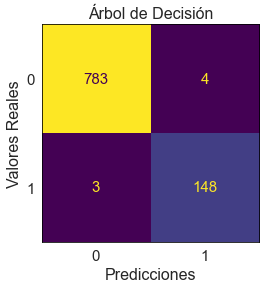

In [27]:
# Score y Confusion Matrix

# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('Árbol de Decisión', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

## Árbol (esquema)

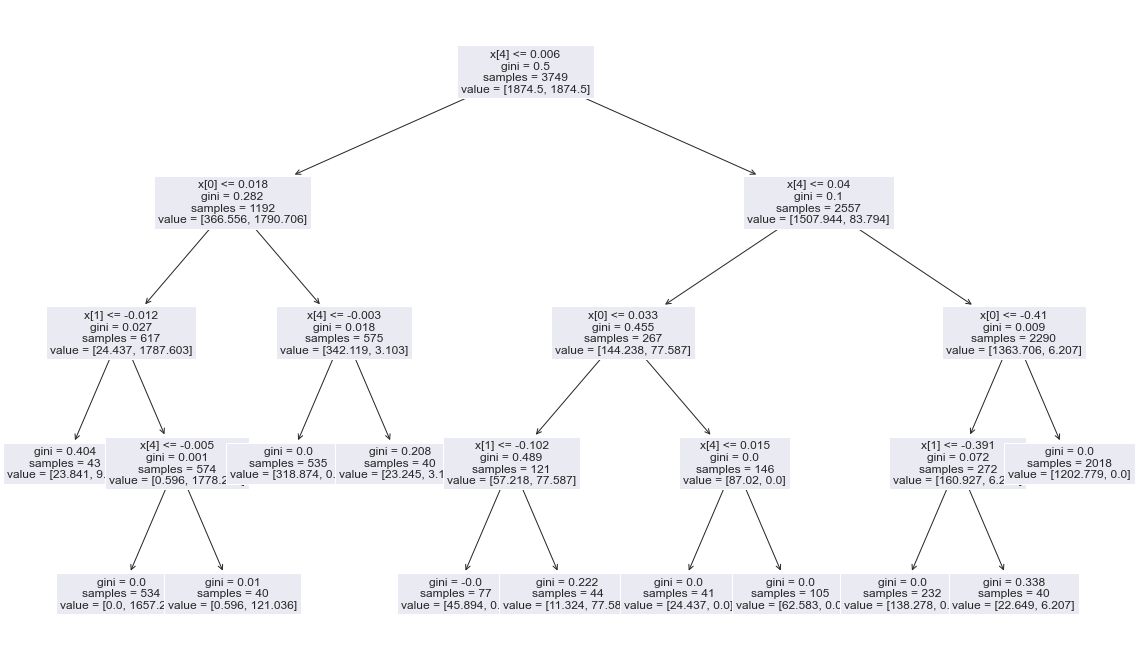

In [42]:
from sklearn import tree

plt.figure(figsize=(20, 12))  # Ajusta el tamaño de la figura a tus necesidades
tree.plot_tree(selected_model.named_steps['algorithm'], fontsize=12)
plt.show()

----
## Importancia de las variabs

In [16]:
gsearch.best_estimator_.named_steps['algorithm'].feature_importances_
# ERROR: no sé porque si pongo esta línea aquí, en lugar 276 importancias me devuelve solo 5... :(

array([0.323, 0.045, 0.   , 0.   , 0.632])

In [17]:
# ## Importancia de las variabs

# # ELIGE 1 OPCIÓN:
# # 1) si queremos ver la importancia de las variabs seleccionadas
# importances = selected_model.named_steps['algorithm'].feature_importances_
# feature_names = select_names

# #    ~ ~    ~ ~    ~ ~    ~ ~    ~ ~    ~ ~    ~ ~    ~ ~    ~ ~    ~ ~
# # # 2) si queremos ver la importancia de todas las variabs
# # ct_names_all = grid_model.best_estimator_.named_steps['column_transform'].get_feature_names_out()
# # poly_names_all = grid_model.best_estimator_.named_steps['polynomial'].get_feature_names_out(input_features=ct_names_all)

# # importances = importances_all
# # feature_names = poly_names_all

# # comprobar qué opción estamos implementando:
# print(len(importances))
# [i for i in feature_names]

5


['scaler__Minimum Orbit Intersection',
 'scaler__Est Dia in M(max)_raiz2',
 'encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

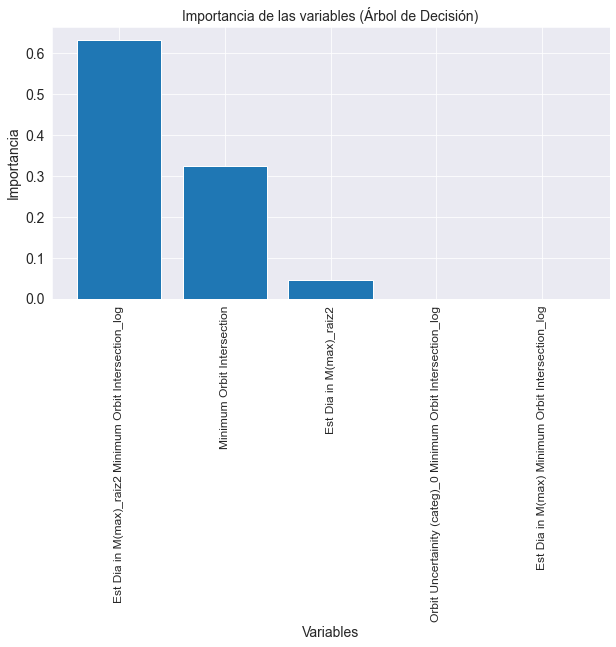

In [23]:
# Tenemos la importancia y las variables seleccionadas:
importances = selected_model.named_steps['algorithm'].feature_importances_
feature_names = select_names

# Crear un dataframe con la información
df_importances = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Ordenar las variables por su importancia
df_importances = df_importances.sort_values('Importancia', ascending=False)

# (recortar el nombre de las variabs, sino es muy largo)
df_importances['Variable'] = df_importances['Variable'].\
                                replace(['scaler__', 'encoder__'], '', regex=True)

# Gráfico de barras
plt.figure(figsize=(10,5))
# Como son demasiadas variabs, mostramos solo las n mejores:
n = 10
plt.bar(df_importances['Variable'][0:n], df_importances['Importancia'][0:n])
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14) 
plt.title('Importancia de las variables (Árbol de Decisión)', fontsize=14) 
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()

In [43]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model2.pkl', 'wb') as f:
    pickle.dump(cv_scores[modelo_optimo], f)